# Alter Ego Chess Engine

The purpose of the project is to create a simple chess engine trained using Neural Networks. The benchmark for the engine is an ability to win 4 out of 5 games against my friends (~1000-1500 elo)

Dataset -> https://www.kaggle.com/datasets/mysarahmadbhat/online-chess-games

In [4]:
import numpy as np
import pandas as pd

In [5]:
data_df = pd.read_csv('./data/chess_games.csv')
data_df.tail()

,game_id,rated,turns,victory_status,winner,time_increment,white_id,white_rating,black_id,black_rating,moves,opening_code,opening_moves,opening_fullname,opening_shortname,opening_response,opening_variation
20053,20054,True,24,Resign,White,10+10,belcolt,1691,jamboger,1220,d4 f5 e3 e6 Nf3 Nf6 Nc3 b6 Be2 Bb7 O-O Be7 Ne5...,A80,2,Dutch Defense,Dutch Defense,NaN,NaN
20054,20055,True,82,Mate,Black,10+0,jamboger,1233,farrukhasomiddinov,1196,d4 d6 Bf4 e5 Bg3 Nf6 e3 exd4 exd4 d5 c3 Bd6 Bd...,A41,2,Queen's Pawn,Queen's Pawn,NaN,NaN
20055,20056,True,35,Mate,White,10+0,jamboger,1219,schaaksmurf3,1286,d4 d5 Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd...,D00,3,Queen's Pawn Game: Mason Attack,Queen's Pawn Game,NaN,Mason Attack
20056,20057,True,109,Resign,White,10+0,marcodisogno,1360,jamboger,1227,e4 d6 d4 Nf6 e5 dxe5 dxe5 Qxd1+ Kxd1 Nd5 c4 Nb...,B07,4,Pirc Defense,Pirc Defense,NaN,NaN
20057,20058,True,78,Mate,Black,10+0,jamboger,1235,ffbob,1339,d4 d5 Bf4 Na6 e3 e6 c3 Nf6 Nf3 Bd7 Nbd2 b5 Bd3...,D00,3,Queen's Pawn Game: Mason Attack,Queen's Pawn Game,NaN,Mason Attack


In [6]:
white_rating = data_df['white_rating']
victory_status = data_df['victory_status']
turns = data_df['turns']

print(f"There are {white_rating.where(white_rating <= 1000).count()} games with rating <= 1000 out of total games {len(data_df)}")
print(f"There are {victory_status.where(victory_status == 'Mate').count()} games that ended up with mates out of total games {len(data_df)}")
print(f"There are {turns.where(turns >= 30).count()} games have more than 30 turns out of total games {len(data_df)}")

There are 249 games with rating <= 1000 out of total games 20058
There are 6325 games that ended up with mates out of total games 20058
There are 16715 games have more than 30 turns out of total games 20058


In [7]:
test_game = data_df['moves'][2]
test_game_moves = test_game.split(' ')
test_game_moves

['e4',
 'e5',
 'd3',
 'd6',
 'Be3',
 'c6',
 'Be2',
 'b5',
 'Nd2',
 'a5',
 'a4',
 'c5',
 'axb5',
 'Nc6',
 'bxc6',
 'Ra6',
 'Nc4',
 'a4',
 'c3',
 'a3',
 'Nxa3',
 'Rxa3',
 'Rxa3',
 'c4',
 'dxc4',
 'd5',
 'cxd5',
 'Qxd5',
 'exd5',
 'Be6',
 'Ra8+',
 'Ke7',
 'Bc5+',
 'Kf6',
 'Bxf8',
 'Kg6',
 'Bxg7',
 'Kxg7',
 'dxe6',
 'Kh6',
 'exf7',
 'Nf6',
 'Rxh8',
 'Nh5',
 'Bxh5',
 'Kg5',
 'Rxh7',
 'Kf5',
 'Qf3+',
 'Ke6',
 'Bg4+',
 'Kd6',
 'Rh6+',
 'Kc5',
 'Qe3+',
 'Kb5',
 'c4+',
 'Kb4',
 'Qc3+',
 'Ka4',
 'Bd1#']

Let's try to think a little bit about the neural network. Basically a chess board is a 8x8 matrix, we can use it as input right away. As for the output, for now we want to simply predict next move, without doing any "fancy" SOTA techniques. We can represent output as probabilities of "from_square" & "to_square" encoded in 4096 vector

The encoded version is calculated by:

$$position_{from} * 63 + position_{to}$$

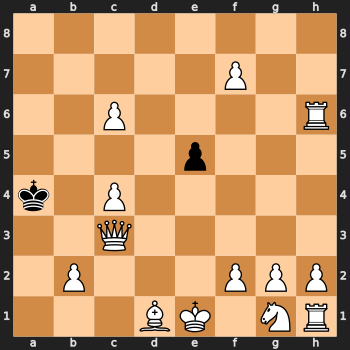

In [12]:
import chess
import chess.svg
import time
from IPython.display import SVG, display, clear_output

board = chess.Board()

for move in test_game_moves:
    clear_output(wait=True)
    board.push_san(move)
    display(SVG(chess.svg.board(board, size=350)))
    time.sleep(1)


In [17]:
board.piece_at(chess.A4).piece_type

6

In [33]:
def get_square_position(square):
    letter_ascii = ord(square[0])
    digit = int(square[1])

    return (letter_ascii - ord('a')) + (8 * (digit - 1))

def encode_position(move):
    from_position = get_square_position(move[0:2])
    to_position = get_square_position(move[2:4])

    return from_position * 63 + to_position

def decode_position(encoded):
    to_position = encoded % 63
    from_position = encoded // 63

    return (from_position, to_position)

def infer_move(board, original):
    move = board.parse_san(original)

    from_square = chess.square_name(move.from_square)
    to_square = chess.square_name(move.to_square)

    return encode_position(from_square + to_square)

The idea is that we train the neural net to simply predict the next move. For that, purpose we will feed board positions, and use the actual move done by the human as label

As an idea for future iterations, we can probably just use winners' moves as training data (still a player can play awfuly during the whole game, but somehow win in the end)

In [34]:
print(chess.PAWN)
print(chess.KNIGHT)
print(chess.BISHOP)
print(chess.ROOK)
print(chess.QUEEN)
print(chess.KING)

1
2
3
4
5
6


In [101]:
UNIQUE_PIECES = 6

def encode_piece(piece_type, is_white):
    if is_white:
        return piece_type

    return piece_type + UNIQUE_PIECES

# form input (1-d 64 elements array) & output (1-d 4096 elements array)
# each move is basically a separate training example
def preprocess_game(moves):
    board = chess.Board()
    split_moves = moves.split(' ')

    X_list = []
    y_list = []

    for move in split_moves:
        # fill input matrix (flattened)
        flattened_X = np.zeros(64, dtype=np.float32)
        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece:
                flattened_X[square] = encode_piece(piece_type=piece.piece_type, is_white=piece.color)
        
        # fill output (encoded)
        label = infer_move(board, move)

        board.push_san(move)

        X_list.append(flattened_X)
        y_list.append(label)

    return np.array(X_list), np.array(y_list)

In [51]:
import torch
from torch import nn

In [95]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 4096),
        )
    
    def forward(self, x):
        return self.layers(x)

model = NeuralNetwork().to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

In [103]:
size = len(data_df['moves'])

def train(X, y, model, loss_fn, optimizer, batch):
    model.train()

    X = torch.from_numpy(X).to(device)
    y = torch.from_numpy(y).to(device)

    prediction = model(X)
    loss = loss_fn(prediction, y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch % 100 == 0:
        loss, current = loss.item(), batch + 1
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [107]:
for batch, raw_moves in enumerate(data_df['moves']):
    (X, y) = preprocess_game(raw_moves)

    train(X, y, model, loss_fn, optimizer, batch)

print("Done!")

loss: 4.148124  [    1/20058]
loss: 5.888808  [  101/20058]
loss: 5.020072  [  201/20058]
loss: 6.008907  [  301/20058]
loss: 6.193636  [  401/20058]
loss: 4.439474  [  501/20058]
loss: 6.376595  [  601/20058]
loss: 5.479107  [  701/20058]
loss: 6.023677  [  801/20058]
loss: 6.271746  [  901/20058]
loss: 3.698902  [ 1001/20058]
loss: 5.862080  [ 1101/20058]
loss: 6.331590  [ 1201/20058]
loss: 5.650950  [ 1301/20058]
loss: 5.748524  [ 1401/20058]
loss: 5.793408  [ 1501/20058]
loss: 5.436454  [ 1601/20058]
loss: 4.693330  [ 1701/20058]
loss: 4.503688  [ 1801/20058]
loss: 5.964903  [ 1901/20058]
loss: 6.245866  [ 2001/20058]
loss: 5.281727  [ 2101/20058]
loss: 5.947711  [ 2201/20058]
loss: 5.527960  [ 2301/20058]
loss: 3.726487  [ 2401/20058]
loss: 5.456801  [ 2501/20058]
loss: 5.267366  [ 2601/20058]
loss: 5.644419  [ 2701/20058]
loss: 5.759718  [ 2801/20058]
loss: 5.939301  [ 2901/20058]
loss: 5.839557  [ 3001/20058]
loss: 5.332757  [ 3101/20058]
loss: 3.957634  [ 3201/20058]
loss: 5.46